In [1233]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
from tinygp import kernels, GaussianProcess
import jax
from jax.scipy import linalg
import jax.numpy as jnp
import optax
from tqdm.notebook import trange, tqdm
from tinygp.noise import Diagonal
from tqdm import notebook
jax.config.update("jax_enable_x64", True)
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

In [1234]:
sigma_epsilon = 5 # jitter ontop of smooth variation
N=12              # Number of data samples
Domain = [-10,10] # Domain of parameters
LR = 3e-3         # Optimization learning rate 
ITERS = 3000      # max iteration
epsilon = 0.0     # Difference in smoothness from surrogates to high res

In [1235]:
# Toy Models
def get_Q(theta, A=-0.4, B=0.4):
    """
    This is the model which we ultimitely want to predict, represents the 
    smooth variation on some function. 
    """
    return A * theta  +  theta**3*B**4 * np.sin(theta) #+ C * x * theta + D * x

def get_R(theta, epsilon=epsilon, A=-0.4, B=0.4):
    """
    If Surrogates have some different mean function then you can make that 
    here. For simulations of same "resolution" this should return the same
    as Q
    """
    Q = get_Q(theta, A, B)
    delta = epsilon * theta  + epsilon*1/(theta**2+ epsilon)
    return Q + delta

<IPython.core.display.Javascript object>


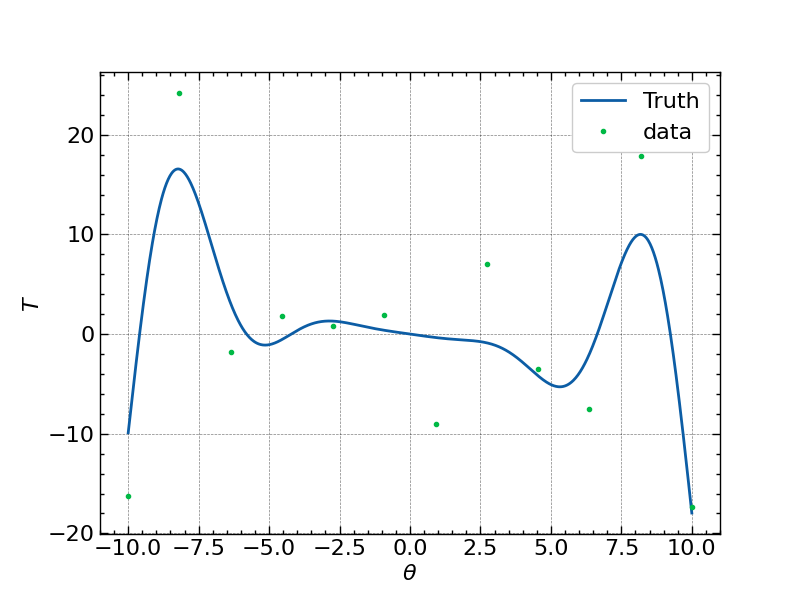

In [1236]:
# underlying truth: 
theta=np.linspace(*np.array(Domain)+0.001, 1001, endpoint=True)
Y = get_Q(theta) 
plt.plot(theta, Y, '-', label='Truth')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$T$')

# Sample Data
np.random.seed(194)
theta_Q = np.linspace(Domain[0], Domain[1], N, )
Q_raw = get_Q(theta_Q)

np.random.seed(30)
Q = np.random.normal(Q_raw, sigma_epsilon,N)
intrinsic_noise = Q - Q_raw

plt.plot(theta_Q, Q, '.', label='data')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$T$')
plt.legend()

# Minimization and Prediction functions

## General functions

These functions just do decomposition of the covariance matrix for faster computation: Heavily taken from tinyGP

In [1195]:
@jax.jit
@jax.value_and_grad
def loss(params, kernel_func, X, Y, jitter=None, off_diag=None, kernel_M=None):
    """
    Return the loss and gradient of the loss for gradient descent
    """
    # Build Kernel with current parameter values
    kernel = kernel_func(params)
    N = len(X)
    # Add noise
    if jitter is None:
        cov = kernel(X, X) + jnp.exp(params['log_jitter']) * jnp.eye(N)
    else:
        p = 20 / (1 + jnp.exp(-params["log_pl"])) - 10
        MK = Mkernel(jnp.exp(-p))
        # Off diagonal elements are weighed by linear exponential
        M = off_diag*MK(X, X) * jnp.exp(params['log_jitter']) + jnp.eye(N)*jnp.exp(params['log_jitter'])
        cov = kernel(X, X) + M
    # Compute liklihood
    alpha, scale_tril = decomp(cov, Y, params['mean'])
    L = log_liklihood(scale_tril, alpha)

    return -L

def predict(Y, cov, cov_new, mu_y):
    """
    mean = Ks C^{-1} (Y-\mu_Y) + \mu_Y
    cov = Kss - Ks C^{-1}Ks^T
    
    Ks = covariance of new thetas with old thetas, 
    Kss= covariance of new thetas
    C  = covariance from GP
    x  = Value of params
    gp_mean = mean function
    
    returns mean and cov
    """
    
    ltn = cov_new.shape[0] - cov.shape[0]
    mean = cov_new[:ltn, ltn:] @ np.linalg.inv(cov)@(Y - mu_y) + mu_y
    cov = cov_new[:ltn, :ltn] - cov_new[:ltn, ltn:] @ np.linalg.inv(cov) @  cov_new[:ltn, ltn:].T
    return mean, cov


In [1196]:
# For speeding up inverse calculations Do a cholesky decomposition

@jax.jit
def decomp(cov, Q, mean):
    scale_tril = linalg.cholesky(cov, lower=True)
    alpha = linalg.solve_triangular(scale_tril, Q-mean, lower=True)
    return alpha, scale_tril

@jax.jit
def invdecomp(cov, Q, mean):
    scale_tril = linalg.cholesky(cov, lower=True)
    alpha = linalg.solve_triangular(scale_tril, Q-mean, lower=True, trans=1)
    return alpha, scale_tril

@jax.jit
def log_liklihood(scale_tril, alpha):
    return  -0.5 * jnp.sum(jnp.square(alpha)) - jnp.sum(jnp.log(jnp.diag(scale_tril))) + 0.5 * scale_tril.shape[0] * np.log(2 * np.pi)

## Surrogate Functions

In [1197]:
def match_surrogates0(theta, intrinsic_noise, Groups=4, f=0):
    ## Different split approach
    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(Groups).fit(theta.reshape(-1,1))
    labels = sorted(clustering.labels_)
    unique_ls, counts = np.unique(labels, return_counts=True)
    sorted_args = np.argsort(theta_Q)
    theta_R = np.concatenate([[np.mean(theta[labels==i])]*c for i, c in zip(unique_ls, counts)])
    noises = np.concatenate([intrinsic_noise[labels==i] for i, c in zip(unique_ls, counts)])
    surrogate_raw = get_Q(theta_R)
    surrogate_data = surrogate_raw + noises*(1-f) + f*np.random.normal(0, sigma_epsilon, len(theta_R)) 
    return theta_R, surrogate_data, surrogate_raw

In [1198]:
# def match_surrogates0(theta_Q, noise, f, div=5):
#     """
#     Match surrogates noise levels at the mean values of the Q. This is pretty
#     arbitrary and can be set up numerous ways. Here I just find mean of a group
#     of N_R points and set that as the surrogate, then match the noise of each
#     of the points in that group
#     """
    
#     N_R = int(N/div)
#     theta_R = theta_Q.reshape(N_R, -1)
#     theta_R = theta_R.mean(axis=1).repeat(div, axis=0)
#     matched_noise = (1-f)*noise + f * np.random.normal(0, sigma_epsilon, len(noise))
#     R       = get_Q(theta_R) + matched_noise
#     cov = np.var(np.reshape(R, (N_R, -1)), axis=-1).repeat(div)
#     return theta_R, R, np.diag(cov)

## CARPool functions

In [1199]:
from tinygp import kernels
class GPMixture(kernels.Kernel):
    """
    Custom kernel for carpool with \Delta P parameter
    """
    def __init__(self, amp, tau, delta_p=0):
        self.amp = jnp.atleast_1d(amp)
        self.tau = jnp.atleast_1d(tau)
        self.delta_p = jnp.atleast_1d(delta_p)
    def evaluate(self, X1, X2):
        x = jnp.atleast_1d(jnp.sqrt((X2 - X1 + self.delta_p)**2))
        return  jnp.prod(self.amp * jnp.exp(-x**2*self.tau))
    
def build_I(N):
    """
    Create an off diagonal identity matrix for M matrix
    """
    I = np.zeros((2*N, 2*N))
    for i in range(N):
        I[i,N+i] = 1
    for i in range(N):
        I[N+i,i] = 1
    return I

class Mkernel(kernels.Kernel):
    """
    linear exponential kernel only applied to the off diagonals. This encodes
    the level of correlation between surrogates and HR sims. The value is 
    transformed using a sigmoid function to bind it between -1 and 1
    """
    def __init__(self, p):
        self.p = jnp.atleast_1d(p)
    def evaluate(self, X1, X2):
        x = jnp.atleast_1d(jnp.sqrt((X2 - X1)**2))
        return  jnp.sum(jnp.exp(-self.p* x))
    
def get_GPMixture(params):
    try:
        K = GPMixture(
            jnp.exp(params["log_amp"]),
            jnp.exp(params["log_tau"]),
            jnp.exp(params["log_p"]))
    except:
        K = GPMixture(
            jnp.exp(params["log_amp"]),
            jnp.exp(params["log_tau"]))
    return K

def get_kernelM(params):
    K = Mkernel(params["log_pl"])
    return K
from tinygp.kernels import ExpSquared
def get_exp2kernel(params):
    return jnp.exp(params["log_amp"]) * ExpSquared(jnp.exp(-params["log_tau"]))

# No Surrogates

We now compare the evaluation of the "true data" using a standard gaussian process. Here its just a squared exponential function that is being used. So this is the simplest case of a smooth GP. 

In [1200]:
# Define the hyper parameters of the GP kernel
paramsQ = {
    "log_amp":2.0,
    "log_tau":-2.0,
    "log_jitter":3.5,
    "mean":0.0}

# Define the kernel function with jax
kernel_func =  jax.tree_util.Partial(get_exp2kernel)

# Optimize by minimizing neg log liklihood
opt = optax.sgd(learning_rate=LR)
opt_state = opt.init(paramsQ)
ls = []
for i in trange(ITERS):
    loss_val, grads = loss(paramsQ, kernel_func, theta_Q, Q)
    updates, opt_state = opt.update(grads, opt_state)
    paramsQ = optax.apply_updates(paramsQ, updates)
    ls.append(loss_val)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [1201]:
noiseQ = jnp.exp(paramsQ['log_jitter']) * jnp.eye(len(theta_Q))

# Create the kernel with the optimal parameters
kernel = get_GPMixture(paramsQ)

#Generate Covariance matricies 
cov = kernel(theta_Q, theta_Q) + noiseQ
pred_cov = kernel(np.concatenate((theta, theta_Q)), np.concatenate((theta, theta_Q)))

# Predict the mean and variance
pred_mean, pred_var = predict(Q, cov, pred_cov, 0)

In [1202]:
plt.plot(theta, pred_mean)
plt.plot(theta, Y)
plt.fill_between(theta, pred_mean+np.sqrt(np.diag(pred_var)), 
                 pred_mean-np.sqrt(np.diag(pred_var)), alpha=0.4, 
                label=r'$1\sigma$ region')
plt.xlabel(r'$\theta$')
plt.ylabel('T')
plt.legend()

# Creating Surrogates

Now we create surrogate samples. Surrogates have noise that is correlated to the datas noise parameterized here by the variable ```f```, where,

$$r=\frac{(1-f)\sigma_Q^2}{\sigma_Q\sqrt{((1-f)^2\sigma^2_Q+f^2 \sigma^2_\eta)}}$$

For an f=0, there is 100% correlation, for an f=1, there is 0 correlation, and in general. We assume that the surrogates and the HR simulations are drawn from the same distribution and have the same noise, but this need not be the case. We could have "cheaper" simulations that have some other noise function. 

In [1203]:
div = 2
N_R = int(N/div)
f=0.00

theta_R, R, E = match_surrogates0(theta_Q, intrinsic_noise, Groups=5, f=0)


<IPython.core.display.Javascript object>


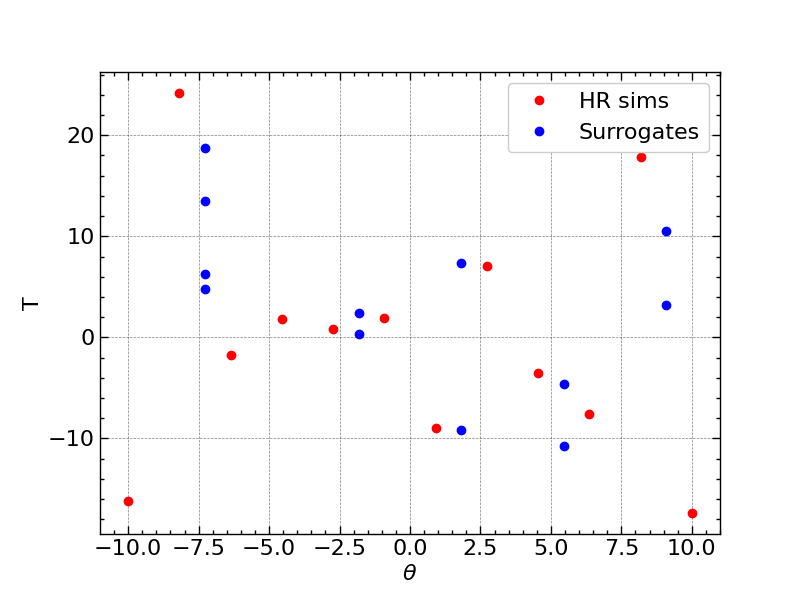

In [1205]:
# We can plot the islands of surrogates with the HR sims
fig, ax = plt.subplots()
ax.plot(theta_Q ,Q, 'ro', label=r'HR sims')
ax.plot(theta_R ,R, 'bo', label=r'Surrogates')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'T')

ax.legend()

# Combining The two

Now we want to combine the HR sims and the surrogates. for this we need some matrix M which has the variance, $\sigma^2$ we predicted from earlier along the diagonal and is $r(\theta)\sigma^2$ along the off diagonals where the surrogates and HR sims have matching ICs. $r$ needs to change when according to distance from surrogate and we assume that this happens rather sharply, using a linear exponential function. $$r = \exp\left(-|p| \|\theta_i - \theta_j\|_D^{1/2}\right)$$,

In [1206]:
theta_QR = np.concatenate((theta_Q, theta_R))
QR = np.concatenate((Q, R))
jitter = np.exp(paramsQ['log_jitter'])
I = build_I(N) # This is an off diagonal matrix of 1s

In [1207]:
# We want to learn the correlation parameter r and  here as well
paramsCP = {
    "log_amp":0.1,
    "log_tau":1.0,
    "log_jitter":3.0,
    "log_pl":2.0,
    "mean":0.0}

kernel_func =  jax.tree_util.Partial(get_GPMixture)


# If you are getting nans, try making the LR smaller
opt = optax.sgd(learning_rate=LR)
opt_state = opt.init(paramsCP)
ls = []
ps = []
for i in trange(9000):
    loss_val, grads = loss(paramsCP, kernel_func, theta_QR, QR, jitter=jitter, off_diag=I)
    updates, opt_state = opt.update(grads, opt_state)
    paramsCP = optax.apply_updates(paramsCP, updates)
    ps.append(paramsCP.values())
    ls.append(loss_val)

  0%|          | 0/9000 [00:00<?, ?it/s]

In [1208]:
%matplotlib inline

Text(0.5, 0, 'Iters')

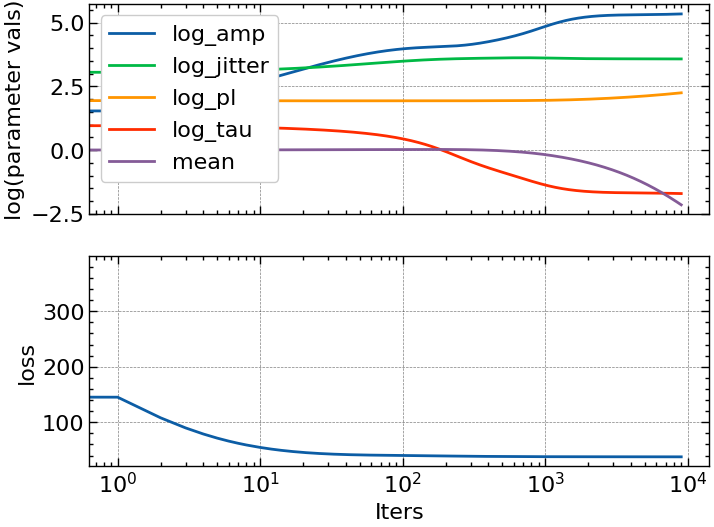

In [1209]:
fig, axs = plt.subplots(nrows=2, sharex=True)
ps_i = [[list(p)[i] for i in range(len(paramsCP.keys()))] for p in ps]
axs[1].semilogx(ls)
for i in range(len(paramsCP.keys())):
    axs[0].semilogx(np.array(ps_i)[:, i], label=list(paramsCP.keys())[i])

axs[0].legend()
axs[0].set_ylabel('log(parameter vals)')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('Iters')

In [1210]:
# Create the kernel
kernel = get_GPMixture(paramsCP)
p = 20 / (1 + np.exp(-paramsCP["log_pl"])) - 10
M = Mkernel(np.exp(-p))

# Generate the covariance matrices from the kernel
#r = 1/ (1 + np.exp(-paramsCP["pl"]))
noise =I* M(theta_QR, theta_QR) * np.exp(paramsCP['log_jitter']) + np.eye(2*N)*jnp.exp(paramsCP['log_jitter'])
cov = kernel(theta_QR, theta_QR)+noise
pred_cov = kernel(np.concatenate((theta, theta_QR)), np.concatenate((theta, theta_QR)))

# Predict the mean and cov
pred_meanCP, pred_varCP = predict(QR, cov, pred_cov, paramsCP['mean'])

To more clearly see how the noise matrix works, we show the variance of the off diagonal element as a function of the parameter values. We plot vertical lines where the surrogates are located. This shows that when the HR sims have parameters closest to the surrogates they have a variance that is the most correlated. As we move away from the surrogates, the correlation decreases and with it goes the variance. 

Text(0, 0.5, '$\\sigma^2$')

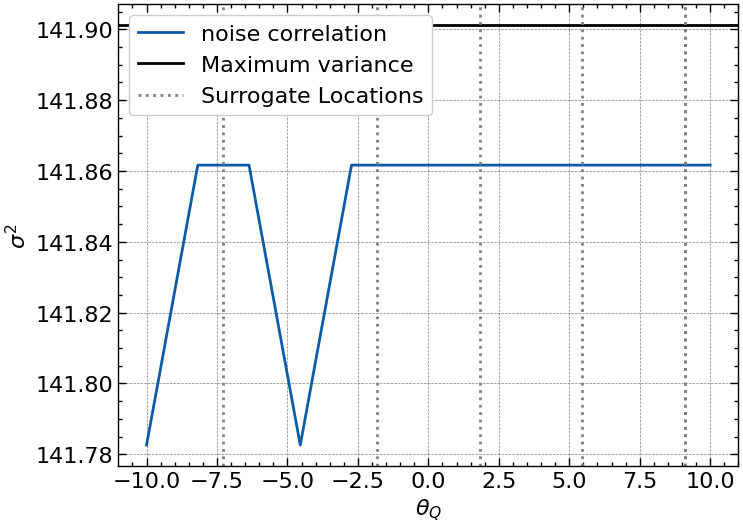

In [1211]:
off_D = M(theta_QR, theta_QR) * I * jitter
plt.plot(theta_Q, [off_D[i, N+i] for i in range(N)], label='noise correlation')
plt.axhline(jitter, ls='-', c='k', label='Maximum variance')
for tr in np.unique(theta_R):
    plt.axvline(tr, c='grey', ls=':')
plt.axvline(tr, c='grey', ls=':', label='Surrogate Locations')
plt.legend()
plt.xlabel(r'$\theta_Q$')
plt.ylabel('$\sigma^2$')
# plt.ylim(1, 5)

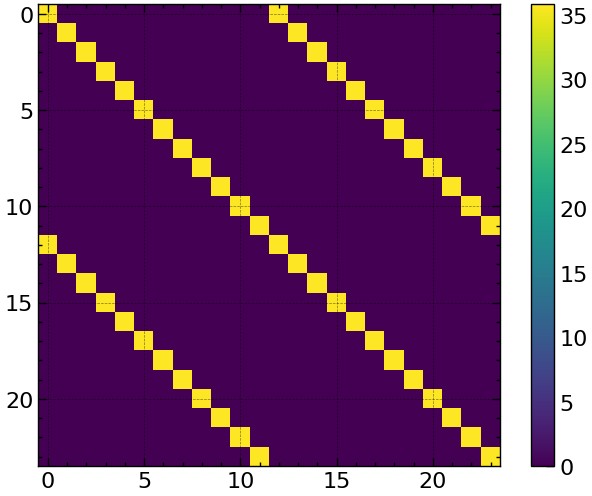

In [1212]:
plt.imshow(noise)
plt.colorbar()

# Comparing with more data points?

How does carpool compare to just using more data? Lets find out by using double the number of samples with a standard squared exponential kernel and looking at the result. For a succesful CARPool we hope to reduce the $\chi^2$ and come closer to the true function

In [1221]:
paramsQ2 = {
    "log_amp":0.0,
    "log_tau":0.0,
    "log_jitter":0.0,
    "mean":0.0
}
np.random.seed(125)
newtQ = np.random.uniform(*Domain, N*2)
np.random.seed(12345)
newQ = get_Q(newtQ) + np.random.normal(0, sigma_epsilon, len(newtQ))


# Choose the kernel to use
kernel_func = jax.tree_util.Partial(get_exp2kernel)

opt = optax.sgd(learning_rate=LR)
opt_state = opt.init(paramsQ2)
ls = []
for i in trange(ITERS):
    loss_val, grads = loss(paramsQ2, kernel_func, newtQ, newQ)
    updates, opt_state = opt.update(grads, opt_state)
    paramsQ2 = optax.apply_updates(paramsQ2, updates)
    ls.append(loss_val)
    
    
noiseQ2 = jnp.exp(paramsQ2['log_jitter']) * jnp.eye(len(newtQ))

# Create the kernel with the optimal parameters
kernel = get_exp2kernel(paramsQ2)

#Generate Covariance matricies 
cov = kernel(newtQ, newtQ) + noiseQ2
pred_cov = kernel(np.concatenate((theta, newtQ)), np.concatenate((theta, newtQ)))

# Predict the mean and variance
pred_mean2, pred_var2 = predict(newQ, cov, pred_cov, 0)

  0%|          | 0/3000 [00:00<?, ?it/s]

$\chi^2$ for CARPool: 238.5497450928256


Text(0, 0.5, 'Q')

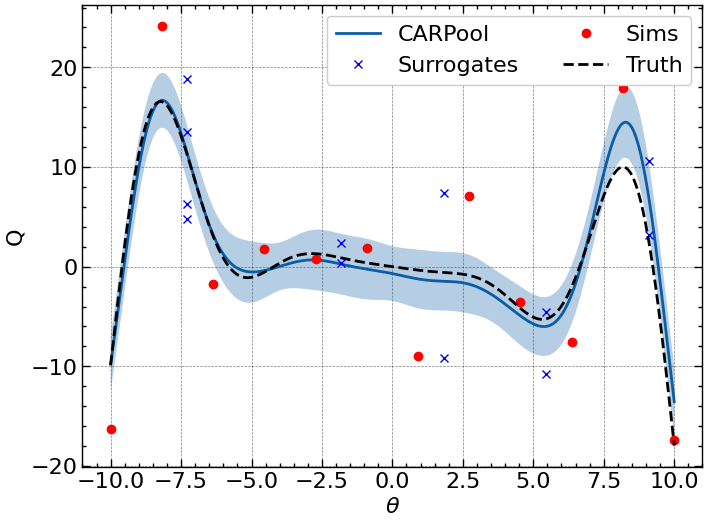

In [1226]:
mu = pred_meanCP
std = np.sqrt(np.diag(pred_varCP))
plt.plot(theta, mu, label="CARPool")
plt.fill_between(theta, np.array(mu)+std, np.array(mu)-std, alpha=0.3)
print(r'$\chi^2$ for CARPool: ' + f'{np.sum((Y - mu)**2/std**2)}')


# mu = pred_mean2
# plt.plot(theta, mu, label="No Surrogates")
# std = np.sqrt(np.diag(pred_var2))
# plt.fill_between(theta, np.array(mu)+std, np.array(mu)-std, alpha=0.3)
# print(r'$\chi^2$'  + f' for No Surrogates: {np.sum((Y - mu)**2/std**2)}')

# plt.plot(newtQ ,newQ, 'ro', label=r'Sims')
plt.plot(theta_R ,R, 'bx', label=r'Surrogates')
plt.plot(theta_Q ,Q, 'ro', label=r'Sims')

plt.plot(theta, Y, '--k', label='Truth')
plt.legend(ncol=2)
plt.xlabel(r'$\theta$')
plt.ylabel('Q')

In [1179]:
def predict_GP(paramsGP, theta, Q, test_theta):
    noise = jnp.exp(paramsGP['log_jitter']) * jnp.eye(len(theta))

    # Create the kernel with the optimal parameters
    kernel = get_exp2kernel(paramsGP)

    #Generate Covariance matricies 
    cov = kernel(theta, theta) + noise
    pred_cov = kernel(np.concatenate((test_theta, theta)), np.concatenate((test_theta, theta)))

    # Predict the mean and variance
    pred_mean, pred_var = predict(Q, cov, pred_cov, paramsGP['mean'])
    return pred_mean, pred_var

In [1180]:
def predict_CP(paramsCP, theta, theta_R, data, surrogate_data, test_theta):
    theta_QR = np.concatenate((theta.T, theta_R))
    QR = np.concatenate((data, surrogate_data))
    I = build_I(len(theta.T))
    
    # Create the kernel
    kernel = get_GPMixture(paramsCP)
    p = 20 / (1 + np.exp(-paramsCP["log_pl"])) - 10
    M = Mkernel(np.exp(-p))

    # Generate the covariance matrices from the kernel
    #r = 1/ (1 + np.exp(-paramsCP["pl"]))
    noise =I * M(theta_QR, theta_QR) * np.exp(paramsCP['log_jitter']) + np.eye(2*len(theta.T))*jnp.exp(paramsCP['log_jitter'])
    cov = kernel(theta_QR, theta_QR)+noise
    pred_cov = kernel(np.concatenate((test_theta.T, theta_QR)), np.concatenate((test_theta.T, theta_QR)))

    # Predict the mean and cov
    pred_meanCP, pred_varCP = predict(QR, cov, pred_cov, paramsCP["mean"])
    return pred_meanCP, pred_varCP

In [1181]:
def find_new_points_GP(paramsGP, theta, data, theta_grid, test_theta, num_new=20):
    theta_grid = np.random.uniform(test_theta[0], test_theta[-1], 100)
    pred_meanGP, pred_varGP = predict_GP(paramsGP, theta, data, theta_grid)
    var = np.diag(pred_varGP)

    # Now we find where the largest covariance is in this grid
    args = np.argsort(var)
    biggest_var = args[-num_new:]

    # This corresponds to these thetas
    next_thetas = theta_grid[biggest_var]

    # Lets generate some data at these points
    next_Q_raw = get_Q(next_thetas)

    next_Q = np.random.normal(next_Q_raw, sigma_epsilon,len(next_thetas))
    next_intrinsic_noise = next_Q - next_Q_raw
    
    # We want to now run new simulations at these theta points
    new_theta = np.append(theta, next_thetas)
    new_Q =  np.append(data, next_Q)

  
    paramsGP2 ={
    "log_amp":0.1,
    "log_tau":1.0,
    "log_jitter":3.0,
    "mean":0.0}


    # Choose the kernel to use
    kernel_func = jax.tree_util.Partial(get_exp2kernel)

    opt = optax.sgd(learning_rate=LR)
    opt_state = opt.init(paramsGP2)
    ls = []
    for i in trange(9000):
        loss_val, grads = loss(paramsGP2, kernel_func, new_theta, new_Q)
        updates, opt_state = opt.update(grads, opt_state)
        paramsGP2 = optax.apply_updates(paramsGP2, updates)
        ls.append(loss_val)
    pred_meanGP, pred_varGP = predict_GP(paramsGP2, new_theta, new_Q, test_theta)
    
    return pred_meanGP, pred_varGP, paramsGP2, new_theta, new_Q

In [1182]:
def find_new_points(paramsCP, theta, theta_R, data, surrogate_data, theta_grid, test_theta, num_new=20):
    theta_grid = np.random.uniform(test_theta[0], test_theta[-1], 100)
    pred_meanCP, pred_varCP = predict_CP(paramsCP, theta, theta_R, data, surrogate_data, theta_grid)
    var = np.diag(pred_varCP)

    # Now we find where the largest covariance is in this grid
    args = np.argsort(var)
    biggest_var = args[-num_new:]

    # This corresponds to these thetas
    next_thetas = theta_grid[biggest_var]

    # Lets generate some data at these points
    next_Q_raw = get_Q(next_thetas)

    next_Q = np.random.normal(next_Q_raw, sigma_epsilon,len(next_thetas))
    next_intrinsic_noise = next_Q - next_Q_raw
    
    # We want to now run new simulations at these theta points
    new_theta = np.append(theta, next_thetas)
    new_Q =  np.append(data, next_Q)

    # We need to add surrogates for these points as well? 
    surrogate_locs = np.unique(theta_R)
    
    new_tr = []
    new_r = []
    for tq, nq in zip(next_thetas, next_intrinsic_noise):
        tr = np.argmin((tq - surrogate_locs)**2)
        r = get_Q(surrogate_locs[tr]) + nq
        new_tr.append(surrogate_locs[tr])
        new_r.append(r)
    new_theta_R = np.append(theta_R, new_tr)
    new_surrogates = np.append(surrogate_data, new_r)
    new_theta_QR = np.concatenate((new_theta, new_theta_R))
    
    new_QR = np.concatenate((new_Q, new_surrogates))
    
    
    jitter = np.exp(paramsCP['log_jitter'])
    I = build_I(len(new_theta)) # This is an off diagonal matrix of 1s
    N = len(new_theta)
    paramsCP2 ={
    "log_amp":0.1,
    "log_tau":1.0,
    "log_jitter":3.0,
    "log_pl":1.0,
    "mean":0.0}


    kernel_func =  jax.tree_util.Partial(get_GPMixture)


    # If you are getting nans, try making the LR smaller
    opt = optax.sgd(learning_rate=LR)
    opt_state = opt.init(paramsCP2)
    ls = []
    ps = []
    for i in trange(9000):
        loss_val, grads = loss(paramsCP2, kernel_func, new_theta_QR, new_QR, jitter=jitter, off_diag=I)
        updates, opt_state = opt.update(grads, opt_state)
        paramsCP2 = optax.apply_updates(paramsCP2, updates)
        ps.append(paramsCP2.values())
        ls.append(loss_val)
    pred_meanCP, pred_varCP = predict_CP(paramsCP2, new_theta, new_theta_R, new_Q, new_surrogates, test_theta)
    
    return pred_meanCP, pred_varCP, paramsCP2, new_theta, new_theta_R, new_Q, new_surrogates

In [1183]:
N_total = 2*N # This is the number of surrogates and sims we currently have. 
N_desired = 20*N # This is the total number of simulations we can run
N_per_iter = 2*8 # So we add 3 new simulations, and that comes with 3 new surrogates
N_iters = (N_desired - N_total)//N_per_iter # This is the number of reps we do
N_HR_per_iter = N_per_iter//2

In [1184]:
N_total, N_desired, N_iters, N_HR_per_iter

(24, 240, 13, 8)

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

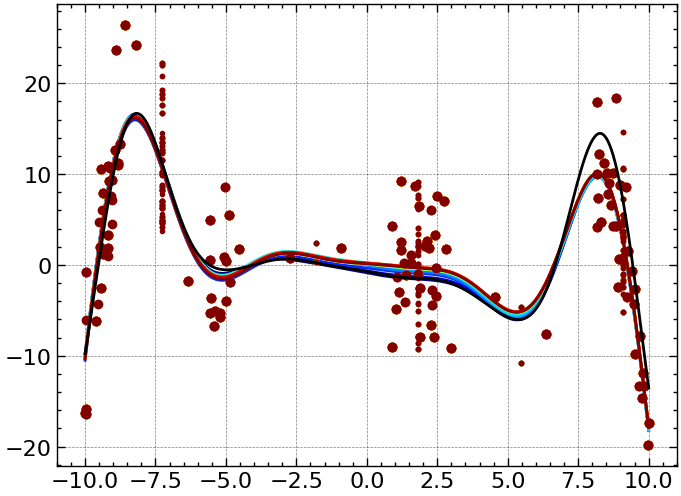

In [1185]:
theta_grid = np.linspace(theta[0], theta[1], 500)
test_theta = theta
p = paramsCP
tq = theta_Q
tr = theta_R
q = Q
r = R
plt.figure()
cs = plt.cm.jet(np.linspace(0, 1,N_iters))
Ms, Vs, ps, tqs, trs, qs, rs = [],[],[],[],[],[],[]
for i in range(N_iters):
    M, V, p, tq, tr, q, r = find_new_points(p, tq, tr, q, r, test_theta, test_theta, num_new=N_HR_per_iter)
    Ms.append(M)
    Vs.append(V)
    ps.append(p)
    tqs.append(tq)
    trs.append(tr)
    qs.append(q)
    rs.append(r)
    plt.plot(test_theta, M ,c=cs[i])
    plt.plot(tq, q, 'o', c=cs[i])
    plt.plot(tr, r, '.', c=cs[i])
plt.plot(test_theta, pred_meanCP,'k')

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

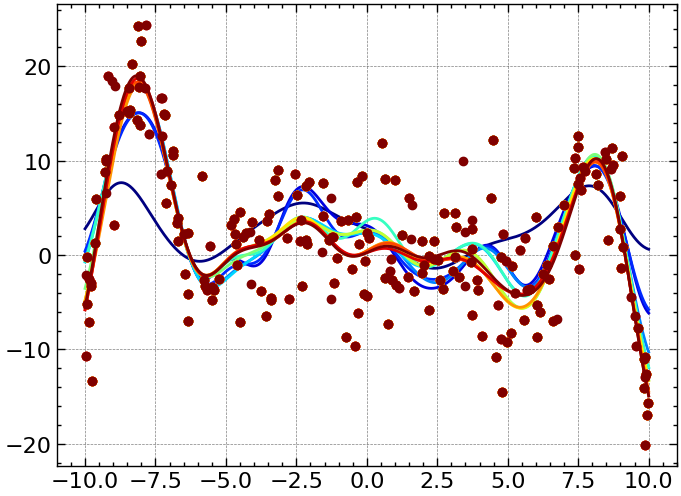

In [1186]:
theta_grid = np.linspace(theta[0], theta[1], 500)
test_theta = theta
p = paramsQ2
tq = newtQ
q = newQ
plt.figure()
cs = plt.cm.jet(np.linspace(0, 1,N_iters))
Msgp, Vsgp, psgp, tqsgp, qsgp = [],[],[],[],[]
for i in range(N_iters):
    M, V, p, tq, q = find_new_points_GP(p, tq, q, test_theta, test_theta, num_new=2*N_HR_per_iter)
    Msgp.append(M)
    Vsgp.append(V)
    psgp.append(p)
    tqsgp.append(tq)
    qsgp.append(q)
    plt.plot(test_theta, M ,c=cs[i])
    plt.plot(tq, q, 'o', c=cs[i])
#     plt.plot(tr, r, '.', c=cs[i])
# plt.plot(test_theta, pred_meanGP2,'k')

We want to compare this with some thing that has N_desired elements

In [1187]:
paramsQ2 = {
    "log_amp":1.0,
    "log_tau":1.0,
    "log_jitter":2.0,
    "mean":0.0
}
np.random.seed(123)
newtQ = np.random.uniform(*Domain, N_desired)
np.random.seed(12345)
newQ =  np.random.normal(get_Q(newtQ), sigma_epsilon, len(newtQ))


# Choose the kernel to use
kernel_func = jax.tree_util.Partial(get_exp2kernel)

opt = optax.sgd(learning_rate=LR)
opt_state = opt.init(paramsQ2)
ls = []
for i in trange(9000):
    loss_val, grads = loss(paramsQ2, kernel_func, newtQ, newQ)
    updates, opt_state = opt.update(grads, opt_state)
    paramsQ2 = optax.apply_updates(paramsQ2, updates)
    ls.append(loss_val)
noiseQ2 = jnp.exp(paramsQ2['log_jitter']) * jnp.eye(len(newtQ))

# Create the kernel with the optimal parameters
kernel = get_exp2kernel(paramsQ2)

#Generate Covariance matricies 
cov = kernel(newtQ, newtQ) + noiseQ2
pred_cov = kernel(np.concatenate((theta, newtQ)), np.concatenate((theta, newtQ)))

# Predict the mean and variance
pred_mean2, pred_var2 = predict(newQ, cov, pred_cov, 0)

  0%|          | 0/9000 [00:00<?, ?it/s]

In [1229]:
%matplotlib notebook

<IPython.core.display.Javascript object>


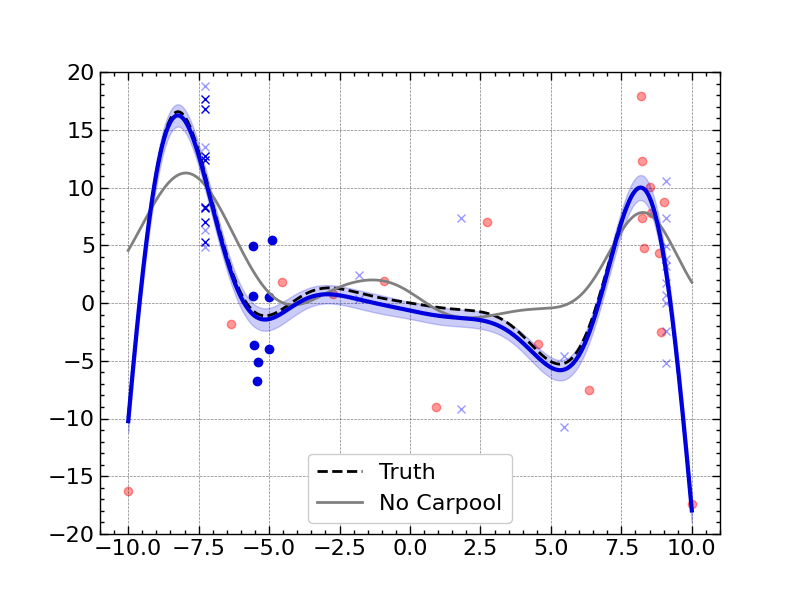

In [1231]:
from matplotlib.animation import FuncAnimation, PillowWriter

# create empty lists for the x and y data
x = []
y = []

# create the figure and axes objects
fig, ax = plt.subplots()
cs = plt.cm.jet(np.linspace(0, 1, len(Ms)))
def animate(i):
    ax.clear()
    ax.set_ylim(-20, 20)
    ax.plot(theta, get_Q(theta), '--k', label='Truth')
    ax.plot(theta, pred_mean2, 'grey', label='No Carpool')

    ax.plot(theta, Ms[i], c=cs[i], lw=3)
    ax.fill_between(theta, Ms[i] + np.diag(Vs[i]), Ms[i] - np.diag(Vs[i]), color=cs[i], alpha=0.2)
   
    new_qs = np.isin(tqs[i], tqs[i-1], invert=True)
    old_qs = np.isin(tqs[i], tqs[i-1])
    ax.plot(tqs[i][new_qs], qs[i][new_qs], 'o', c=cs[i], zorder=-2)
    ax.plot(trs[i][new_qs], rs[i][new_qs], 'x', c=cs[i], zorder=-2)
    ax.plot(tqs[i][old_qs], qs[i][old_qs], 'o', c='r', zorder=-2, alpha=0.3)
    ax.plot(trs[i][old_qs], rs[i][old_qs], 'x', c='b', zorder=-2, alpha=0.3)
    ax.legend()

    
ani = FuncAnimation(fig, animate, frames=len(Ms), interval=1000, repeat=True)
writergif = PillowWriter(fps=30) 
# ani.save('ani.gif')

<IPython.core.display.Javascript object>


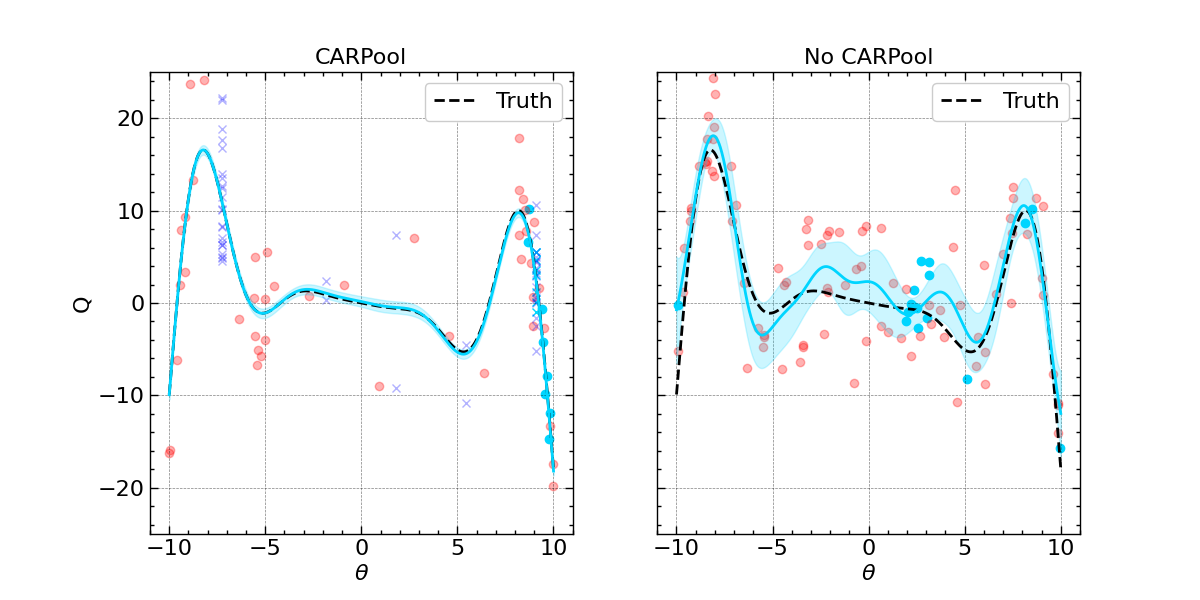

In [1232]:
from matplotlib.animation import FuncAnimation, PillowWriter

# create empty lists for the x and y data
x = []
y = []

# create the figure and axes objects
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,6))
cs = plt.cm.jet(np.linspace(0, 1, len(Ms)))
csgp = plt.cm.jet(np.linspace(0, 1, len(Msgp)))

def animate(i):
    ax[0].clear()
    ax[0].set_ylim(-20, 20)
    ax[0].plot(theta, get_Q(theta), '--k', label='Truth')
    ax[0].plot(theta, Ms[i], c=cs[i], lw=2)
    ax[0].fill_between(theta, Ms[i] + np.diag(Vs[i]), Ms[i] - np.diag(Vs[i]), color=cs[i], alpha=0.2)
   
    new_qs = np.isin(tqs[i], tqs[i-1], invert=True)
    old_qs = np.isin(tqs[i], tqs[i-1])
    ax[0].plot(tqs[i][new_qs], qs[i][new_qs], 'o', c=cs[i], zorder=-2)
    ax[0].plot(trs[i][new_qs], rs[i][new_qs], 'x', c=cs[i], zorder=-2)
    ax[0].plot(tqs[i][old_qs], qs[i][old_qs], 'o', c='r', zorder=-2, alpha=0.3)
    ax[0].plot(trs[i][old_qs], rs[i][old_qs], 'x', c='b', zorder=-2, alpha=0.3)
    ax[0].legend()
    ax[0].set_title('CARPool')
    
    ax[1].clear()
    ax[1].set_ylim(-25, 25)
    ax[1].plot(theta, get_Q(theta), '--k', label='Truth')
    ax[1].plot(theta, Msgp[i], c=csgp[i], lw=2)
    ax[1].fill_between(theta, Msgp[i] + np.diag(Vsgp[i]), Msgp[i] - np.diag(Vsgp[i]), color=csgp[i], alpha=0.2)
   
    new_qs = np.isin(tqsgp[i], tqsgp[i-1], invert=True)
    old_qs = np.isin(tqsgp[i], tqsgp[i-1])
    ax[1].plot(tqsgp[i][new_qs], qsgp[i][new_qs], 'o', c=csgp[i], zorder=-2)
    ax[1].plot(tqsgp[i][old_qs], qsgp[i][old_qs], 'o', c='r', zorder=-2, alpha=0.3)
    ax[1].legend()
    ax[1].set_title('No CARPool')
    
    ax[1].set_xlabel(r'$\theta$')
    ax[0].set_xlabel(r'$\theta$')
    ax[0].set_ylabel('Q')

    
ani = FuncAnimation(fig, animate, frames=len(Ms), interval=1000, repeat=True)
# writergif = PillowWriter(fps=30) 
ani.save('ani2.gif')

Text(0, 0.5, '$\\chi^2$')

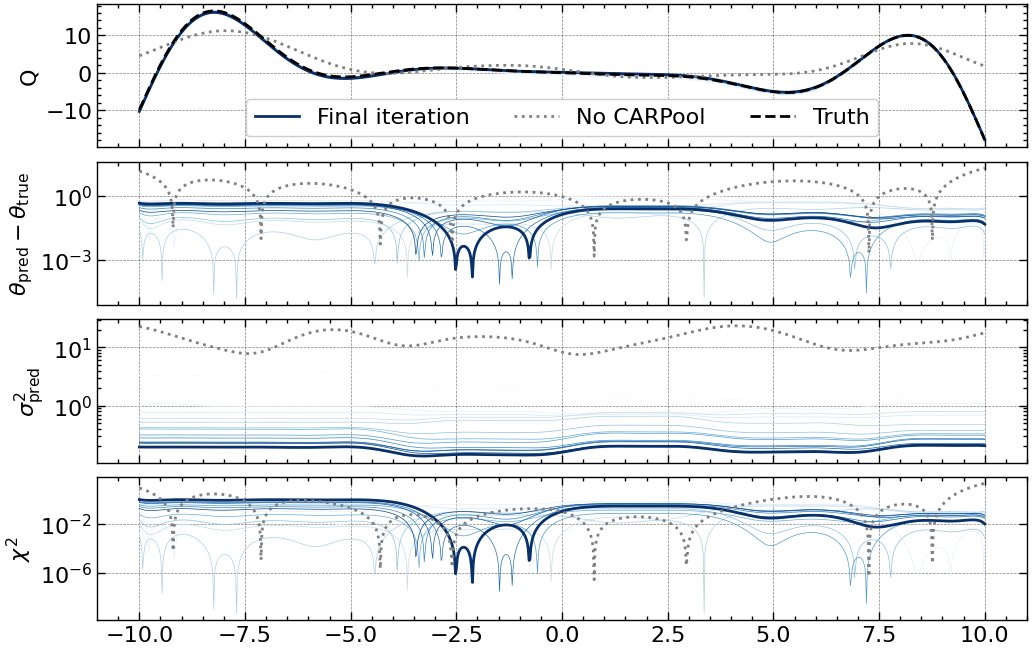

In [1227]:
fig, axs = plt.subplots(nrows=4, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(12, 8))
cs = plt.cm.Blues(np.linspace(0, 1,N_iters))

# Plot the fits to the data
for i, M in enumerate(Ms):
    axs[0].plot(theta, M, c=cs[i], lw=0.5)
axs[0].plot(theta, M, c=cs[-1], lw=2, label='Final iteration')
axs[0].plot(theta, pred_mean2, c='grey', lw=2, ls=':', label='No CARPool')
axs[0].plot(theta, get_Q(theta), c='k', lw=2, ls='--', label='Truth')
axs[0].legend(ncol=3)

# Plot the residuals
for i, M in enumerate(Ms):
    axs[1].semilogy(theta, np.abs(M - get_Q(theta)), c=cs[i], lw=0.5)
axs[1].plot(theta,     np.abs(M - get_Q(theta)), c=cs[-1], lw=2)
axs[1].plot(theta, np.abs(pred_mean2- get_Q(theta)), c='grey', lw=2, ls=':')

# Plot the errors
for i, V in enumerate(Vs):
    axs[2].semilogy(theta, np.diag(V), c=cs[i], lw=0.5)
axs[2].plot(theta, np.diag(V), c=cs[-1], lw=2)
axs[2].plot(theta, np.diag(pred_var2), c='grey', lw=2, ls=':')

# Plot the chi2s
for i, (M, V) in enumerate(zip(Ms, Vs)):
    axs[3].semilogy(theta, (M - get_Q(theta))**2/np.diag(V), c=cs[i], lw=0.5)
axs[3].plot(theta, (M - get_Q(theta))**2/np.diag(V), c=cs[-1], lw=2)
axs[3].plot(theta, (pred_mean2 - get_Q(theta))**2/np.diag(pred_var2), c='grey', lw=2, ls=':')


axs[0].set_ylabel('Q')
axs[1].set_ylabel(r'$\theta_{\rm pred} - \theta_{\rm true}$')
axs[2].set_ylabel(r'$\sigma_{\rm pred}^2$')
axs[3].set_ylabel(r'$\chi^2$')